# Fig09-ColdPool-CTT-CSS
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 28.12.2019
    Date last modified: 28.12.2019

    ##############################################################
    Purpos:

    1) Reads in cold pool and CTT temperature characteristics from
        /glade/u/home/prein/papers/Idealized-MCSs/programs/ColdPools/ColdPoolProperties.py
        /glade/u/home/prein/papers/Idealized-MCSs/programs/IceCloud/IceCloudProperties.py
        
    2) plot changes in min. cloud top temperature and cold pool intensity

In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
# import shapely.geometry
# import descartes
import shapefile
import math
from scipy.stats.kde import gaussian_kde
from math import radians, cos, sin, asin, sqrt
from scipy import spatial
import matplotlib.path as mplPath
from pylab import *
from scipy.optimize import curve_fit
import scipy
import math
import SkewT
from scipy.interpolate import interp1d
from thermodynamics import Theta
# from astropy.io import ascii

In [2]:
################################################################################
################################################################################
#                            Settings

rgrGridSpacing=['12000','12000nc','4000','2000','1000','500','250']
rgrDX=[12000,12000,4000,2000,1000,500,250]
sSimDir='/glade/p/mmm/c3we/Idealized_MCSs/data/WRF/'

rgrGridSpacing=['12000','12000nc','4000','2000','1000','500','250']
rgsDXcol=['#1f78b4','#6a3d9a','#33a02c','#b2df8a','#fdbf6f','#ff7f00','#e31a1c']
sGrid='12km'  # can be 'native' for native grid or '12km' for 12 km model grid
rgrDX=[12000,12000,4000,2000,1000,500,250]
sDataDir='/glade/scratch/prein/Papers/Idealized_MCSs/data/Coldpools/'+sGrid+'/'

rgsSimulations=['19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',

                '64_2012-06-17_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '58_2009-06-08_PGW_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '41_2005-06-10_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '68_2013-07-07_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '31_2006-08-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '16_2002-06-11_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '34_2010-07-12_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '51_2003-06-23_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '56_2008-06-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '35_2004-07-02_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5']
iEvents=10 # number of events that will be considered

sPlotDir='/glade/u/home/prein/papers/Idealized-MCSs/plots/Fig09-ColdPool-CTT-CCS/'

rgiDomSize=[51,51,155,311,623,1247,2495]
iOutInt=12 # slizes per hour
ihours=7 # runtime in hours
iSkipH=3 # hours that should be excluded from the simulation
iRadPmax=60000. # m
iRadVol=100000. # m for the volume calculation

Levels=16 # number of model levels that should be read in
rgrDXnative=250

height_v = np.linspace(0,24000-250,96); height_v=height_v/1000.
height_z = np.linspace(125,24000,95); height_z=height_z/1000.
Smooth=12000 # smoothing filter lenth in m

### Load cold pool intensity data

In [3]:
CP_volume=np.zeros((85,len(rgsSimulations),len(rgrGridSpacing))); CP_volume[:]=np.nan
CP_depth=np.copy(CP_volume)
CP_intensity=np.copy(CP_volume)
CP_speed=np.copy(CP_volume)
CP_extend=np.copy(CP_volume)

for si in range(len(rgsSimulations)):
    print '    Load '+rgsSimulations[si]
    grDATA={}
    for dx in range(len(rgrGridSpacing)):
        try:
            fname=sDataDir+rgsSimulations[si]+'_'+rgrGridSpacing[dx]+'m_Smooth-12km.pkl'
            dbfile = open(fname, 'rb')      
            grDATA[rgrGridSpacing[dx]] = pickle.load(dbfile) 
        except:
            continue
    for dx in range(len(rgrGridSpacing)):
        try:
            Data_Act=grDATA[rgrGridSpacing[dx]]
        except:
            continue

        sMetrix=Data_Act['rgsMetricCPall']
        CP_volume[:,si,dx]=Data_Act['rgrCPPorpAll'][sMetrix.index('Volume'),:][:85]
        CP_depth[:,si,dx]=Data_Act['rgrCPPorpAll'][sMetrix.index('MeanDepth'),:][:85] # [sMetrix.index('P95Depth'),:][:85]
        CP_extend[:,si,dx]=Data_Act['rgrCPPorpAll'][sMetrix.index('Area'),:][:85] # [sMetrix.index('P95Depth'),:][:85]
        Obj_Nr=Data_Act['IntenseCPs'].keys()
        ObjCharact=np.zeros((3,85,len(Obj_Nr))); ObjCharact[:]=np.nan
        for ob in range(len(Obj_Nr)):
            ObjCharact[0,:,ob]=Data_Act['IntenseCPs'][Obj_Nr[ob]]['rgrCP_Max'][:85] # max int.
            ObjCharact[1,1:,ob]=Data_Act['IntenseCPs'][Obj_Nr[ob]]['rgrObjSpeed'][:84] # speed
            ObjCharact[2,:,ob]=Data_Act['IntenseCPs'][Obj_Nr[ob]]['rgrCP_Vol'][:85]
        ObjCharact[ObjCharact == 0]=np.nan
        CP_vol=np.nansum(ObjCharact[2,:,:], axis=0)
        Largest_CP=np.argmax(CP_vol)

        CP_intensity[:,si,dx]=ObjCharact[0,:,Largest_CP]
        CP_speed[:,si,dx]=ObjCharact[1,:,Largest_CP]

    Load 19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 64_2012-06-17_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 58_2009-06-08_PGW_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 41_2005-06-10_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 68_2013-07-07_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 31_2006-08-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 16_2002-06-11_PGW_Mid

### LOAD CTT

In [10]:
rgrGridSpacing=['12000','12000nc','4000','2000','1000','500','250']
rgsDXcol=['#1f78b4','#6a3d9a','#33a02c','#b2df8a','#fdbf6f','#ff7f00','#e31a1c']
sGrid='12km'  # can be 'native' for native grid or '12km' for 12 km model grid
rgrDX=[12000,12000,4000,2000,1000,500,250]
sDataDir='/glade/scratch/prein/Papers/Idealized_MCSs/data/IceClouds/'+sGrid+'/'

rgsSimulations=['19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',

                '64_2012-06-17_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '58_2009-06-08_PGW_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '41_2005-06-10_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '68_2013-07-07_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '31_2006-08-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '16_2002-06-11_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '34_2010-07-12_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '51_2003-06-23_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '56_2008-06-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '35_2004-07-02_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5']

iEvents=10 # number of events that will be considered

sPlotDir='/glade/u/home/prein/papers/Idealized-MCSs/plots/IceClouds/'

rgiDomSize=[51,51,155,311,623,1247,2495]
ihours=7 # runtime in hours

Cloud_area=np.zeros((85,len(rgsSimulations),len(rgrGridSpacing))); Cloud_area[:]=np.nan
T_CT_mean=np.copy(Cloud_area)
T_CT_max=np.copy(Cloud_area)

for si in range(len(rgsSimulations)):
    print '    Load '+rgsSimulations[si]
    grDATA={}
    for dx in range(len(rgrGridSpacing)):
        try:
            fname=sDataDir+rgsSimulations[si]+'_'+rgrGridSpacing[dx]+'m.pkl'
            dbfile = open(fname, 'rb')
            DATA=pickle.load(dbfile)
            T_CT_mean[:,si,dx]=DATA['CTH'][:,0]
            T_CT_max[:,si,dx]=DATA['CTH'][:,1]
            Cloud_area[:,si,dx]=DATA['IceCloud_HE']
            # replace zero with nan
            Cloud_area[Cloud_area == 0]=np.nan
            T_CT_mean[T_CT_mean == 0]=np.nan
            T_CT_max[T_CT_max == 0]=np.nan
        except:
            continue

    Load 19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 64_2012-06-17_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 58_2009-06-08_PGW_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 41_2005-06-10_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 68_2013-07-07_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 31_2006-08-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 16_2002-06-11_PGW_Mid

### Plotting

        Plot map to: /glade/u/home/prein/papers/Idealized-MCSs/plots/IceClouds/Fig09_ColdPool-CTT-CCS.pdf


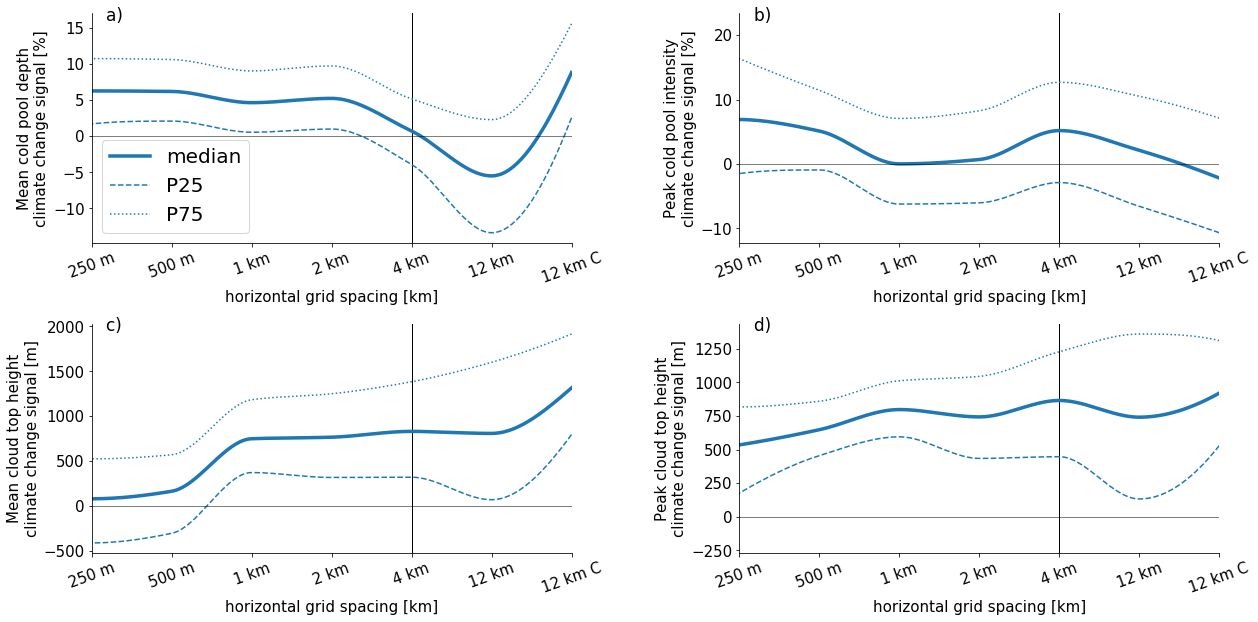

In [26]:
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(18,10))
plt.rcParams.update({'font.size': 15})
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.08, right=0.95,
           bottom=0.2, top=0.95,
           wspace=0.35, hspace=0.35)

# ______________________________________
# PLOT THE COLD POOL INTENSITY CHANGE AND CTT
sVars=['Mean cold pool depth','Peak cold pool intensity','Mean cloud top height','Peak cloud top height']
XX=[0,1,0,1]
YY=[0,0,1,1]
for va in range(len(sVars)):
    if sVars[va] == 'Mean cold pool depth':
        DataAll=CP_depth
        Stat='rel'
        Unit='[%]'
    if sVars[va] == 'Peak cold pool intensity':
        DataAll=CP_intensity
        Stat='rel'
        Unit='[%]'
    elif sVars[va] == 'Mean cloud top height':
        DataAll=T_CT_mean
        Stat='abs'
        Unit='[m]'
    elif sVars[va] == 'Peak cloud top height':
        DataAll=T_CT_max
        Stat='abs'
        Unit='[m]'

    ax = plt.subplot(gs1[YY[va],XX[va]])
    col='#1f78b4'
    iBootstrap=1000
    CurrentBS=np.zeros((iBootstrap,DataAll.shape[2])); CurrentBS[:]=np.nan
    FutureBS=np.copy(CurrentBS)
    for bs in range(iBootstrap):
        Random=np.random.choice(10, 10)
        CurrentBS[bs,:]=np.nanmean(DataAll[12*3:12*5,:10,:][:,Random,:],axis=(0,1))
        FutureBS[bs,:]=np.nanmean(DataAll[12*3:12*5,-10:,:][:,Random,:],axis=(0,1))

    if Stat == 'rel':
        Data_Diff=np.nanpercentile(((FutureBS[:,:]-CurrentBS[:,:])/CurrentBS[:,:])*100., (25,50,75), axis=0)
    else:
        Data_Diff=np.nanpercentile(FutureBS[:,:]-CurrentBS[:,:], (25,50,75), axis=0)
    Xaxis=np.round(np.arange(0,len(rgrGridSpacing)+0.025,0.025),3)
    RealPoints = [np.where(Xaxis == ii)[0][0] for ii in range(len(rgrDX))]

    # median
    DataInt=np.copy(Xaxis); DataInt[:]=np.nan; DataInt[RealPoints[:]]=Data_Diff[1,:]
    s = pd.Series(DataInt)
    plt.plot(Xaxis[::-1], s.interpolate(method='pchip'), c=col, lw=3.5, alpha=1, label='median')
    
    # plot P25-P75
    P25=np.copy(Xaxis); P25[:]=np.nan; P25[RealPoints[:]]=Data_Diff[0,:]
    s25 = pd.Series(P25)
    ax.plot(Xaxis[::-1],s25.interpolate(method='pchip'), c=col, ls='--', label='P25')
    P75=np.copy(Xaxis); P75[:]=np.nan; P75[RealPoints[:]]=Data_Diff[2,:]
    s75 = pd.Series(P75)
    ax.plot(Xaxis[::-1],s75.interpolate(method='pchip'), c=col, ls=':', label='P75')

    xx = (np.array([0.5,1.5, 2.5, 3.5,4.5,5.5,6.5])+0.5)[::-1]
    labels = np.array([ '12 km C',  '12 km',  '4 km', '2 km','1 km','500 m', '250 m'])
    plt.xticks(xx, labels, rotation=20)
    ax.get_xaxis().get_major_formatter().labelOnlyBase = False
    ax.set_ylabel(sVars[va]+'\nclimate change signal '+Unit)
    ax.set_xlabel('horizontal grid spacing [km]')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(1, 7)
    plt.axhline(y=0, c='k', lw=0.5)
    # plt.ylim(Yrange[0],Yrange[1])
    ax.axvline(x=5, ls='-', c='k', zorder=-1, alpha=1, lw=1)

    if va == 0:
        plt.legend(loc="lower left",
                       ncol=1, prop={'size':20})
    ax.text(0.03,0.95, rgsLableABC[va]+') ', ha='left',va='bottom', \
            transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=17)

# Plot the figure
sPlotFile=sPlotDir
sPlotName= 'Fig09_ColdPool-CTT-CCS.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print '        Plot map to: '+sPlotFile+sPlotName
fig.savefig(sPlotFile+sPlotName)

In [6]:
DataAll.shape

(85, 20, 7)